In [2]:
%load_ext autoreload
%autoreload 2
import math
import pprint
from datetime import datetime
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import statsmodels.api as sm
import zipline
from matplotlib import style
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
from tqdm import tqdm_notebook
from trading_calendars.always_open import AlwaysOpenCalendar

import utils

style.use("ggplot")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1

# Get Data

In [4]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1
coint_research_data = utils.combine_market_data("candles/", "USD", "open", True, 
                                                file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv", "BCH-USD.csv"])
coint_research_data.interpolate(inplace=True, method="linear")
coint_research_data.head()

coint_research_data["ETH-USD"] *= ETH_MIN
coint_research_data["BTC-USD"] *= BTC_MIN
#coint_research_data["BCH-USD"] *= BCH_MIN
coint_research_data["LTC-USD"] *= LTC_MIN

coint_research_data = coint_research_data.apply(lambda x: round(x, 3))

['ETH-USD.csv', 'BTC-USD.csv', 'LTC-USD.csv']


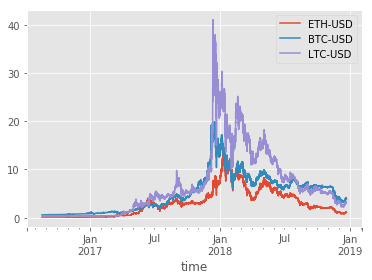

In [5]:
coint_research_data.plot()

In [6]:
pairs_min_weights = {'ETH-USD': ETH_MIN, 'BTC-USD': BTC_MIN, 'BCH-USD': BCH_MIN, 'LTC-USD': LTC_MIN}
backtest_panel = utils.create_zipline_panel("candles/", ('ETH-USD', 'BTC-USD', 'LTC-USD'), 
                                            pairs_min_weights)

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  This is separate from the ipykernel package so we can avoid doing imports until


# Backtest

In [7]:
all_possible_pairs = list(combinations(['ETH-USD', 'BTC-USD', 'LTC-USD'], 2))
all_possible_pairs

[('ETH-USD', 'BTC-USD'), ('ETH-USD', 'LTC-USD'), ('BTC-USD', 'LTC-USD')]

In [20]:
start_date = datetime(2018, 3, 1, 0, 0, 0, 0, pytz.utc)
end_date = datetime(2018, 11, 15, 0, 0, 0, 0, pytz.utc)
total = (end_date - start_date).days
portfolio_value = []

with tqdm_notebook(total=total) as pbar:
    def initialize(context):
        zipline.api.set_benchmark(zipline.api.symbol("BTC-USD"))
        zipline.api.set_commission(zipline.api.commission.PerShare(cost=0, min_trade_cost=0))
        
        context.window_size = None
        context.half_life_coef = 3
        context.z_score_open_thresholds = [1]
        context.z_score_close = 0
        
        context.coint_weights = None
        context.assets = []
        context.z_score_open = 0
        context.is_closing_positions = False
        context.is_in_betting = False
        
        context.coint_z_scores = None
        zipline.api.schedule_function(daily_update, 
                                      date_rule=zipline.api.date_rules.every_day(),
                                      time_rule=zipline.api.time_rules.market_open(hours=1))
        context.is_look_for_new_pair = True
        context.current_allocation_level = 0
        
    def daily_update(context, data):
        cur_portfolio_value = context.portfolio.portfolio_value
        print(f"{zipline.api.get_datetime()}, {zipline.api.get_datetime().weekday()}")
        #print(f"Current Portfolio Value: {cur_portfolio_value}")
        if zipline.api.get_datetime().weekday() == 0:
            context.is_look_for_new_pair = True
        pbar.update(1)
        
    def choose_pair_for_trading(context, data):
        current_datetime = zipline.api.get_datetime()
        month_ago = current_datetime - pd.Timedelta(days=183)
        print(month_ago, current_datetime)
        selected_data = coint_research_data.loc[:current_datetime]
        
        pairs_p_values = np.empty(shape=len(all_possible_pairs))
        for pair_index, (currency1, currency2) in enumerate(all_possible_pairs):
            pair1, pair2 = selected_data[currency1], selected_data[currency2]
            coint_results = coint(pair1, pair2, maxlag=1)
            pairs_p_values[pair_index] = coint_results[1]
        trading_pair1, trading_pair2 = all_possible_pairs[np.argmin(pairs_p_values)]
        context.assets = [zipline.api.symbol(trading_pair1), zipline.api.symbol(trading_pair2)]
        
        model = OLS(selected_data[trading_pair1], sm.add_constant(selected_data[trading_pair2]))
        ols_results = model.fit()
        context.coint_weights = np.array([1, -ols_results.params[trading_pair2]])
        
        coint_series = selected_data[trading_pair1] - selected_data[trading_pair2] * ols_results.params[trading_pair2]
        
        dependent_var = coint_series.diff()[1:]
        independent_var = coint_series.shift(1)[1:]
        independent_var.name = "val_prev"
        model = OLS(dependent_var, sm.add_constant(independent_var))
        ols_results = model.fit()
        mean_reverse_half_life = -np.log(2) / ols_results.params["val_prev"]
        context.window_size = int(mean_reverse_half_life * context.half_life_coef)
        print(f"New pair for trading {trading_pair1} and {trading_pair2}. Half-life: {mean_reverse_half_life}")
        print(f"p-value: {pairs_p_values.min()} || window size: {context.window_size}")
        print(f"Coint weights: {context.coint_weights}")
        print(pairs_p_values)
        context.is_look_for_new_pair = False
        
        context.coint_z_scores = coint_research_data[[trading_pair1, trading_pair2]]
        context.coint_z_scores *= context.coint_weights
        context.coint_z_scores = context.coint_z_scores.sum(axis=1)
        means = context.coint_z_scores.rolling(context.window_size).mean()
        stds = context.coint_z_scores.rolling(context.window_size).std()
        context.coint_z_scores = (context.coint_z_scores - means) / stds
        
            
    def order_assets(context, data, is_long, z_score):
        portfolio_weights = data.history(context.assets, "price", 1, "1m").values[0]
        portfolio_weights *= context.coint_weights
        portfolio_weights /= np.absolute(portfolio_weights).sum()
        if not is_long:
            portfolio_weights *= -1
        
        new_level = 0
        for level_index, z_score_level in enumerate(context.z_score_open_thresholds):
            if abs(z_score) >= z_score_level:
                new_level = level_index + 1
            else:
                break
                
        if new_level > context.current_allocation_level:
            print(f"New allocation level {new_level}")
            if z_score > 0:
                print("Shorting")
            else:
                print("Longing")
            portfolio_weights *= (new_level / len(context.z_score_open_thresholds))
            for asset_index, asset in enumerate(context.assets):
                #print(f"Order {asset} {portfolio_weights[asset_index]}")
                zipline.api.order_target_percent(asset, portfolio_weights[asset_index])

            context.z_score_open = z_score
            context.is_in_betting = True
            context.current_allocation_level = new_level
        
    def close_positions(context, data):
        for order in zipline.api.get_open_orders():
            zipline.api.cancel_order(order)
            
        for asset in context.portfolio.positions.keys():
            zipline.api.order_target_percent(asset, 0)
            
        context.position = 0
        context.z_score_open = 0
        context.is_closing_positions = True
        context.current_allocation_level = 0
    
    def handle_data(context, data):
        positions_amount = len(context.portfolio.positions)
        open_orders_amount = len(zipline.api.get_open_orders()) 
        if context.is_look_for_new_pair and positions_amount == 0 and open_orders_amount == 0:
            choose_pair_for_trading(context, data)
        
        cur_portfolio_value = context.portfolio.portfolio_value
        portfolio_value.append(cur_portfolio_value)
        coint_series = data.history(context.assets, "price", 1, "1m")
        coint_series *= context.coint_weights
        coint_series = coint_series.sum(axis=1)
        
        last_value = coint_series[-1]
        if not np.isnan(last_value):
            z_score = context.coint_z_scores.loc[zipline.api.get_datetime()]
            
            #print("----------------------")
            positions_value = context.portfolio.positions_value
            #print(z_score, cur_portfolio_value)
            #print(zipline.api.get_open_orders())
            
            if positions_amount == 0:
                context.is_closing_positions = False                
            
            if context.is_closing_positions and positions_amount > 0 and open_orders_amount == 0:
                close_positions(context, data)                
            elif not context.is_closing_positions:
                if z_score > context.z_score_open_thresholds[0] and context.z_score_open >= 0 and open_orders_amount == 0:
                    order_assets(context, data, False, z_score)
                elif z_score < -context.z_score_open_thresholds[0] and context.z_score_open <= 0 and open_orders_amount == 0:
                    order_assets(context, data, True, z_score) 
                elif (context.z_score_open > 0 and z_score <= context.z_score_close) or\
                     (context.z_score_open < 0 and z_score >= -context.z_score_close):
                    print("Closing Positions")
                    close_positions(context, data)

    perfomance = zipline.run_algorithm(start=start_date,
                                       end=end_date,
                                       initialize=initialize,
                                       trading_calendar=AlwaysOpenCalendar(),
                                       handle_data=handle_data,
                                       capital_base=1000,
                                       data_frequency='minute',
                                       data=backtest_panel)

2017-08-30 00:00:00+00:00 2018-03-01 00:00:00+00:00
New pair for trading BTC-USD and LTC-USD. Half-life: 9617.771222022606
p-value: 0.0006072779972701223 || window size: 28853
Coint weights: [ 1.         -0.55072067]
[0.31807894 0.0212934  0.00060728]
2018-03-01 00:59:00+00:00, 3
2018-03-02 00:59:00+00:00, 4
New allocation level 1
Shorting


/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


2018-03-03 00:59:00+00:00, 5
2018-03-04 00:59:00+00:00, 6
2018-03-05 00:59:00+00:00, 0
2018-03-06 00:59:00+00:00, 1
2018-03-07 00:59:00+00:00, 2
2018-03-08 00:59:00+00:00, 3
2018-03-09 00:59:00+00:00, 4
Closing Positions
2017-09-07 15:01:00+00:00 2018-03-09 15:01:00+00:00
New pair for trading BTC-USD and LTC-USD. Half-life: 9790.130658085196
p-value: 0.0006403007686293193 || window size: 29370
Coint weights: [ 1.         -0.54593752]
[0.25627585 0.01792922 0.0006403 ]
2018-03-10 00:59:00+00:00, 5
2018-03-11 00:59:00+00:00, 6
2018-03-12 00:59:00+00:00, 0
2017-09-10 01:00:00+00:00 2018-03-12 01:00:00+00:00
New pair for trading BTC-USD and LTC-USD. Half-life: 9848.27877497294
p-value: 0.0006258293021163365 || window size: 29544
Coint weights: [ 1.         -0.54422486]
[0.24513403 0.01730213 0.00062583]
2018-03-13 00:59:00+00:00, 1
2018-03-14 00:59:00+00:00, 2
2018-03-15 00:59:00+00:00, 3
2018-03-16 00:59:00+00:00, 4
2018-03-17 00:59:00+00:00, 5
2018-03-18 00:59:00+00:00, 6
New allocation 

2018-07-20 00:59:00+00:00, 4
2018-07-21 00:59:00+00:00, 5
2018-07-22 00:59:00+00:00, 6
2018-07-23 00:59:00+00:00, 0
2018-07-24 00:59:00+00:00, 1
2018-07-25 00:59:00+00:00, 2
2018-07-26 00:59:00+00:00, 3
2018-07-27 00:59:00+00:00, 4
2018-07-28 00:59:00+00:00, 5
2018-07-29 00:59:00+00:00, 6
2018-07-30 00:59:00+00:00, 0
2018-07-31 00:59:00+00:00, 1
2018-08-01 00:59:00+00:00, 2
2018-08-02 00:59:00+00:00, 3
2018-08-03 00:59:00+00:00, 4
2018-08-04 00:59:00+00:00, 5
Closing Positions
2018-02-02 14:06:00+00:00 2018-08-04 14:06:00+00:00
New pair for trading BTC-USD and LTC-USD. Half-life: 10938.42055074076
p-value: 0.000209045198480694 || window size: 32815
Coint weights: [ 1.         -0.53966286]
[0.11577222 0.00599917 0.00020905]
2018-08-05 00:59:00+00:00, 6
2018-08-06 00:59:00+00:00, 0
2018-02-04 01:00:00+00:00 2018-08-06 01:00:00+00:00
New pair for trading BTC-USD and LTC-USD. Half-life: 10954.5222790945
p-value: 0.00019806798923655025 || window size: 32863
Coint weights: [ 1.         -0.53

Algorithm Period Return: 0.15264332807981207
Aglorithm Period Volatility: 0.14925545628024015
Benchmark Period Return: -0.3747938294363049
Benchmark Period Volatility: 0.5520600829219817


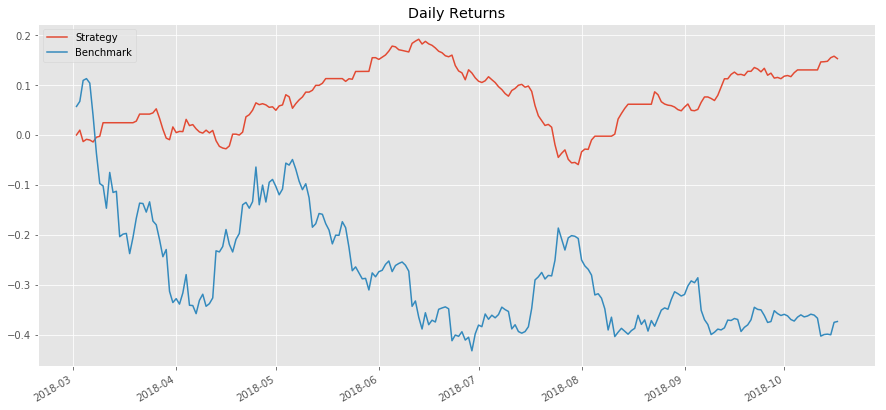

In [21]:
plt.figure(figsize=(15, 7))
plt.title("Daily Returns")
perfomance.algorithm_period_return[:-30].plot(label="Strategy")
perfomance.benchmark_period_return[:-30].plot(label="Benchmark")

print("Algorithm Period Return:", perfomance.algorithm_period_return[-30])
print("Aglorithm Period Volatility:", perfomance.algo_volatility[-30])
print("Benchmark Period Return:", perfomance.benchmark_period_return[-30])
print("Benchmark Period Volatility:", perfomance.benchmark_volatility[-30])
plt.legend();

In [18]:
print("Alpha:", perfomance.alpha[-30])
print("Beta:", perfomance.beta[-30])
print("Max Drawdown:", perfomance.max_drawdown[-30])
print("Sortino:", perfomance.sortino[-30])

Alpha: -0.008200906480435454
Beta: -0.05176870601893023
Max Drawdown: -0.19524514350406025
Sortino: 0.09073617188283394


Sharpe Ratio: 0.06816197207064861


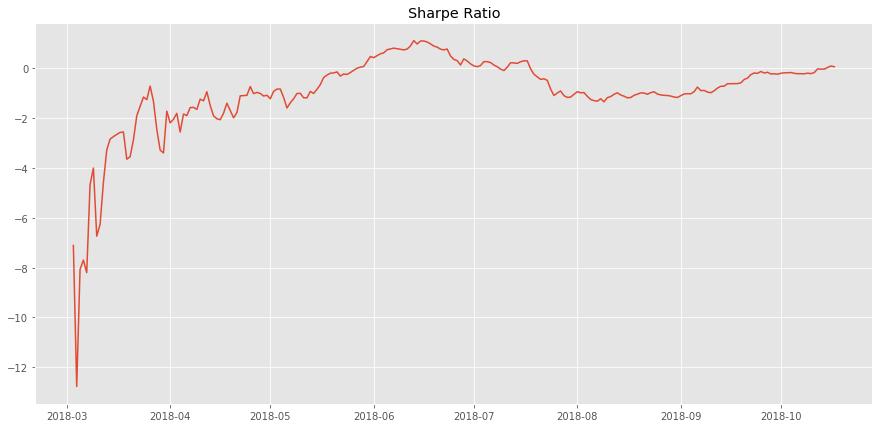

In [19]:
plt.figure(figsize=(15, 7))
plt.title("Sharpe Ratio")
plt.plot(perfomance.sharpe[:-30])
print("Sharpe Ratio:", perfomance.sharpe[-30])